# Angie Chen Button Voting Analysis

In [117]:
import os 
import json
import pandas as pd
import pandasql as ps
from matplotlib import pyplot as plt

### Read Data

In [124]:
# Read CSV files to dataframes
dfs = {"bills":[],
        "documents":[],
        "history":[],
        "people":[],
        "rollcalls":[],
        "sponsors":[],
        "votes":[]}
root = os.path.join(os.getcwd(),"voting_history")
folders = os.listdir(root)
for folder in folders:
    if os.path.isdir(os.path.join(root, folder)):
        path = os.path.join(root, folder, "TX",folder.split("_", 1)[1].split("_CSV_", 1)[0],'csv')
        for df_name in dfs:
            df = pd.read_csv(os.path.join(path,df_name+'.csv'))
            dfs[df_name].append(df)
for df_name in dfs:
    dfs[df_name] = pd.concat(dfs[df_name])
    print(df_name, len(dfs[df_name]))

In [49]:
# Clean 
dfs["people"] = dfs["people"].drop_duplicates(subset=['people_id']) # Keep one arbitrary session as a definition for each person

In [72]:
# Merge votes
voting_record_df = dfs["votes"].merge(dfs["people"], how='left', left_on='people_id', right_on='people_id')
voting_record_df = voting_record_df[voting_record_df.role == "Rep"]

In [73]:
angie_button_id = 5862
voting_record_df.head()

,roll_call_id,people_id,vote,vote_desc,name,first_name,middle_name,last_name,suffix,nickname,...,party,role_id,role,district,followthemoney_eid,votesmart_id,opensecrets_id,ballotpedia,knowwho_pid,committee_id
0,290998,5848,2,Nay,Alma Allen,Alma,A.,Allen,NaN,NaN,...,D,1,Rep,HD-131,6396545,25503,NaN,Alma_Allen,228544,0
1,290998,5849,2,Nay,Roberto Alonzo,Roberto,R.,Alonzo,NaN,NaN,...,D,1,Rep,HD-104,6396552,5468,NaN,Roberto_Alonzo,212608,0
3,290998,5851,4,Absent,Rafael Anchia,Rafael,NaN,Anchia,NaN,NaN,...,D,1,Rep,HD-103,6453425,49874,NaN,Rafael_Anchia,228542,0
4,290998,5852,1,Yea,Charles Anderson,Charles,NaN,Anderson,NaN,Doc,...,R,1,Rep,HD-056,6598949,49739,NaN,Charles_Anderson_(Texas),226950,0
5,290998,5853,1,Yea,Jimmie Aycock,Jimmie,Don,Aycock,NaN,NaN,...,R,1,Rep,HD-054,6667481,57995,NaN,Jimmie_Don_Aycock,248632,0


# Vote Absences
Angie votes consistently, and more frequently than most

In [103]:
# Group votes by politician
grouped = voting_record_df.groupby("people_id")
def percent_abs(group):
    n = sum(group['vote_desc'] == "Absent")
    d = len(group)
    return n/d
abs_votes = grouped.apply(percent_abs)

# Compute rank
abs_votes = abs_votes.to_frame().rename(columns={0:"perc_absent"}).sort_values(by='perc_absent', ascending=True)
abs_votes['rank'] = abs_votes['perc_absent'].rank()

# Show result
print('Total:',len(abs_votes))
abs_votes.loc[angie_button_id]

Total: 270


perc_absent     0.011307
rank           49.000000
Name: 5862, dtype: float64

### Voting Correlation 
Angie has over 16,000 roll call votes. She often votes with the Republican party. She has about 1,000 votes against measures that had sizable Republican support (>75%). 

In [135]:
grouped = voting_record_df.groupby("roll_call_id")

def percent_rep_support(group):
    d = sum(group['vote_desc'] == "Yea")
    if d == 0:
        return None
    n = sum((group['party'] == "R") & (group['vote_desc'] == "Yea"))
    return n/d

rep_votes = grouped.apply(percent_rep_support)
rep_votes = rep_votes.to_frame().rename(columns={0:"perc_rep"}).sort_values(by='perc_rep', ascending=True)

In [136]:
angie_voting_record = voting_record_df[voting_record_df.people_id == angie_button_id]
angie_voting_record = angie_voting_record.merge(rep_votes, how='left', left_on='roll_call_id', right_on='roll_call_id')
print("Angie voting record:")
angie_voting_record['vote_desc'].value_counts()

Angie voting record:


vote_desc
Yea       14529
Nay        1635
Absent      185
NV           12
Name: count, dtype: int64

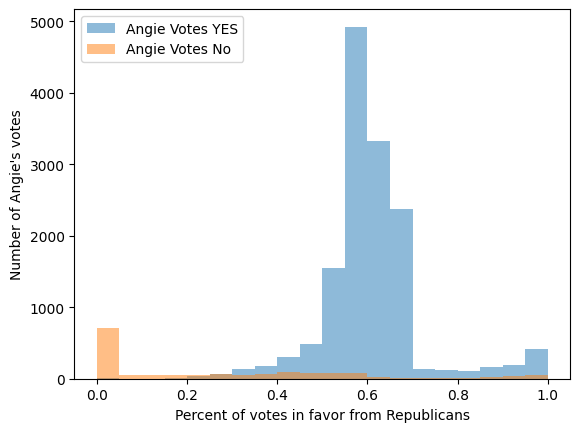

In [147]:
angie_voting_record[angie_voting_record.vote_desc=="Yea"]['perc_rep'].plot.hist(bins=20, alpha=0.5, range=[0, 1])
angie_voting_record[angie_voting_record.vote_desc=="Nay"]['perc_rep'].plot.hist(bins=20, alpha=0.5, range=[0, 1])
plt.ylabel("Angie's votes vs Republican support")
plt.ylabel("Number of Angie's votes")
plt.xlabel("Percent of votes in favor from Republicans") 
plt.legend(["Angie Votes YES", "Angie Votes No"], loc="upper left")

In [151]:
print("Number of Angie's votes against her party:")
sum(angie_voting_record[angie_voting_record.vote_desc=="Yea"]['perc_rep'] > .75)

Number of Angie's votes against her party:


998